In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM,Dropout,Dense

## Data Preprocessing

### reading dataset

In [3]:
data = pd.read_csv('dataset/Google_Stock_Price_Train.csv')
data.sample(3)

,Date,Open,High,Low,Close,Volume
254,1/8/2013,366.40,366.78,360.86,731.29,"3,364,700"
547,3/10/2014,605.58,606.55,599.80,"1,208.25","2,438,200"
868,6/17/2015,529.37,530.98,525.10,529.26,"1,294,200"


In [4]:
train_data = data.iloc[:,1:2].values

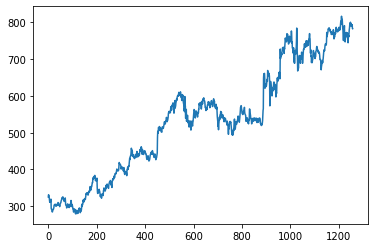

In [5]:
plt.plot(train_data)

### feature scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_scaled = sc.fit_transform(train_data)

### creating datastructure with 60 timestamps and 1 output

In [7]:
x_train = []
y_train = []

for i in range(60,len(train_scaled)):
    x_train.append(train_scaled[i-60:i,0])
    y_train.append(train_scaled[i,0])
x_train , y_train = np.array(x_train) , np.array(y_train)

### reshaping -- add one more dimension

In [8]:
# add one more dimension for the predictors/indicators           -- (btach size , timestamps , (input_dim)predictors )
x_train = np.reshape(x_train, ( x_train.shape[0] , x_train.shape[1] , 1 ))

In [9]:
x_train.shape

(1198, 60, 1)

### Building LSTM

In [33]:
regressor = Sequential()

# LSTM layer1
regressor.add(LSTM(units = 50 , return_sequences=True , input_shape = (x_train.shape[1] , 1) ))
regressor.add(Dropout(0.2))

# LSTM layer2
regressor.add(LSTM(units = 50 , return_sequences=True ))
regressor.add(Dropout(0.2))

# LSTM layer3
regressor.add(LSTM(units = 50 , return_sequences=True ))
regressor.add(Dropout(0.2))

# LSTM layer4
regressor.add(LSTM(units = 50 ))
regressor.add(Dropout(0.2))

# output layer
regressor.add(Dense(units = 1))

In [52]:
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)               

In [34]:
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [35]:
regressor.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
38/38 [==============================] - 19s 150ms/step - loss: 0.0416
Epoch 2/100
38/38 [==============================] - 5s 139ms/step - loss: 0.0063
Epoch 3/100
38/38 [==============================] - 5s 134ms/step - loss: 0.0053
Epoch 4/100
38/38 [==============================] - 5s 130ms/step - loss: 0.0061
Epoch 5/100
38/38 [==============================] - 5s 127ms/step - loss: 0.0049
Epoch 6/100
38/38 [==============================] - 5s 130ms/step - loss: 0.0046
Epoch 7/100
38/38 [==============================] - 5s 131ms/step - loss: 0.0050
Epoch 8/100
38/38 [==============================] - 5s 135ms/step - loss: 0.0059
Epoch 9/100
38/38 [==============================] - 6s 145ms/step - loss: 0.0047
Epoch 10/100
38/38 [==============================] - 5s 131ms/step - loss: 0.0045
Epoch 11/100
38/38 [==============================] - 5s 125ms/step - loss: 0.0047
Epoch 12/100
38/38 [==============================] - 5s 134ms/step - loss: 0.0042
Epoch 13/100

38/38 [==============================] - 6s 158ms/step - loss: 0.0013
Epoch 99/100
38/38 [==============================] - 6s 159ms/step - loss: 0.0015
Epoch 100/100
38/38 [==============================] - 6s 164ms/step - loss: 0.0014


### Evaluating

In [11]:
test_data = pd.read_csv('dataset/Google_Stock_Price_Test.csv')
test_data.sample(2)

,Date,Open,High,Low,Close,Volume
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"
7,1/12/2017,807.14,807.39,799.17,806.36,"1,353,100"


#### test_data preprocessing

In [12]:
tf = pd.concat([data.Open,test_data.Open],axis=0)
tf.index = np.arange(0,len(tf))

In [15]:
inputs = tf[len(tf)-len(test_data)-60:].values

In [19]:
inputs = inputs.reshape(-1,1)

In [20]:
inputs = sc.transform(inputs)

In [28]:
x_test = []
y_test = []

for i in range(60,len(inputs)):
    x_test.append( inputs[i-60:i,0] )
    y_test.append(inputs[i,0])
    
x_test , y_test = np.array(x_test) , np.array(y_test)

In [39]:
# add one more dimension for the predictors/indicators           -- (btach size , timestamps , (input_dim)predictors )
x_test = np.reshape(x_test, ( x_test.shape[0] , x_test.shape[1] , 1 ))

### prediction

In [48]:
y_pred = regressor.predict(x_test)
y_pred = sc.inverse_transform(y_pred)

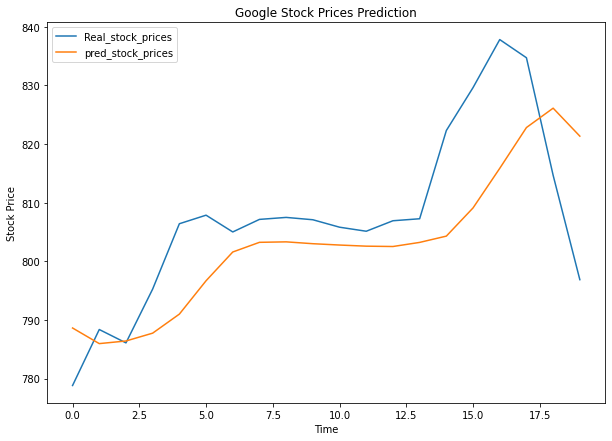

In [75]:
plt.figure(figsize=(10,7))
plt.plot(test_data.Open,label='Real_stock_prices')
plt.plot(y_pred,label='pred_stock_prices')
plt.legend()
plt.title('Google Stock Prices Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()